In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import LinearSVR, SVR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.stats import lognorm

In [2]:
def build_model(inp_shape, x, y):
    group = inp_shape[1]
    # layer definition
    dense_layer = tf.keras.layers.Dense(units=20, activation="sigmoid")
    layer_norm = tf.keras.layers.LayerNormalization()
    drop_out = tf.keras.layers.Dropout(0.3)
    
    # model constant
    inp_dict_x = tf.constant(x, dtype="float32")
    inp_dict_y = tf.constant(y, dtype="float32")
    l_dict_x = inp_dict_x
    l_dict_y = inp_dict_y
    
    
    # input
    inp = tf.keras.layers.Input((group, inp_shape[2]))
    
    
    # model
    l = inp
    l = dense_layer(l)
    l = layer_norm(l)
#     l = drop_out(l)
    
    l_dict_x = dense_layer(l_dict_x)
    l_dict_x = layer_norm(l_dict_x)
#     l_dict_x = drop_out(l_dict_x)
    
    lr = tf.keras.layers.Lambda(lambda x: tf.einsum("ijk,pmk->ijpm", x[0], x[1]), name="raw_score_attn")([l, l_dict_x])
    lr = tf.keras.layers.Lambda(lambda x: tf.keras.backend.permute_dimensions(x, (1, 3, 0, 2)))(lr)
    mask = tf.keras.layers.Lambda(lambda x: 1 - tf.eye(tf.keras.backend.shape(x)[2]), name="mask_generation")(lr)
    lr = tf.keras.layers.Lambda(lambda x: x[0] * x[1], name="masking")([mask, lr])
    lr = tf.keras.layers.Lambda(lambda x: tf.keras.backend.permute_dimensions(x, (2,0,3,1)), name="attn_score")(lr)
    lr = tf.keras.layers.Lambda(lambda x: tf.keras.activations.softmax(x, axis=[2,3]))(lr)
#     lr = drop_out(lr)
    output_q = tf.keras.layers.Lambda(lambda x: tf.einsum("ijpm,pml->ijl", x[0], x[1]), name="after_atten")([lr, l_dict_y])
    output_tot = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1, keepdims=True), name="tot")(output_q)
    
#     model = tf.keras.models.Model(inp, [output_q, output_tot])
    model = tf.keras.models.Model(inp, output_q)
    model.summary()

    optim = tf.keras.optimizers.Adam(learning_rate=5e-2)
    model.compile(loss="mse", optimizer=optim)
    return model

## Real Dataset Demo

In [3]:
df = pd.read_csv("HDD_SHIPMENT_20200415100552.csv")
df["time_bucket"] = pd.to_datetime(df["time_bucket"]).dt.strftime('%Y-%m-%d')
df = df.groupby(["bu", 'item_group', 'time_bucket']).apply(lambda x: pd.Series({
    "quantity": x['quantity'].sum(),
    "commodity": x["commodity"].values[0],
    "inch_interface": x["inch_interface"].values[0],
    "capacity": x["capacity"].values[0],
    "rev": x["rev"].values[0],
    "thickness": x["thickness"].values[0],
    "others": x["others"].values[0]
}    
)).reset_index(drop=False)
df = df.groupby(['item_group', "bu"]).filter(lambda x: (x["quantity"] == 0).sum()/x.shape[0] <= 0.4)
df.loc[:, "quantity"] = df.loc[:, "quantity"] * (df.loc[:, "quantity"] > 0)
df.loc[:, 'rev'] = df.loc[:, 'rev'].replace(np.nan, 'UNK')
df.loc[:, 'thickness'] = df.loc[:, 'thickness'].replace(np.nan, 'UNK')
df.loc[:, 'others'] = df.loc[:, 'others'].replace(np.nan, 'UNK')

In [4]:
print(df.shape)
filter_condition = {
    "HDD 2.5 1TB 7200RPM 7MM,IdeaDT": "2018-08-01",
    "HDD 2.5 1TB 7200RPM 7MM,IdeaNB": "2018-02-01",
    "HDD 2.5 1TB 7200RPM 7MM,ThinkDT": "2018-05-01",
    "HDD 2.5 1TB 7200RPM 7MM,ThinkNB": "2018-05-01",
    "HDD 2.5 2TB 5400RPM 7MM,IdeaDT": "2018-04-01",
    "HDD 2.5 2TB 5400RPM 7MM,ThinkNB": "2018-05-01",
    "HDD 3.5 10TB,ThinkDT": "2018-08-01"
}
res = []
for idx, single_df in df.groupby(["item_group", "bu"]):
    key = ",".join(idx)
    single_df = single_df.loc[lambda x: x.time_bucket >= filter_condition.get(key, "2016-01-01"), :]
    res.append(single_df)
df = pd.concat(res)
print(df.shape)

(1116, 10)
(1023, 10)


In [5]:
qty_df = df.loc[:, ["bu", "item_group", "time_bucket", "quantity"]] \
.pivot_table(index=["bu", "item_group"], columns="time_bucket") \
.replace(np.nan, 0).T.unstack().T.reset_index()
attr_df = df.loc[:, ["bu", "item_group", 'commodity', 'inch_interface', 'capacity', 'rev', 'thickness', 'others']].drop_duplicates()
df = attr_df.merge(qty_df, how="left", on=["item_group", "bu"])

In [6]:
# df = df.loc[lambda x: x["item_group"].isin(['HDD 2.5 1TB 5400RPM 7MM', 'HDD 2.5 1TB 5400RPM 9.5MM',
#                                            'HDD 2.5 1TB 7200RPM 7MM', 'HDD 2.5 1TB 7200RPM 9.5MM', "HDD 3.5 1TB 7200RPM  Hybrid"]), :]
# df = df.loc[lambda x: x["item_group"].isin(['HDD 2.5 1TB 5400RPM 7MM']), :]

In [113]:
standardize = False
logrithm = False

feature_df = df.copy(deep=True).loc[lambda x: x.time_bucket <= '2020-03-01', :]

measure_month = '2019-12-01'
tmp_date_list = pd.date_range(end=pd.to_datetime(measure_month), periods=3, freq="MS").strftime('%Y-%m-%d').tolist()
# tmp = ['2019-12-01', '2020-01-01', '2020-02-01']
train_final_condition = lambda x: x["time_bucket"] < tmp_date_list[0]
test_final_condition = lambda x: x["time_bucket"] >= tmp_date_list[0]

# train_final_condition = lambda x: (~x.time_bucket.isin(tmp + test_date))
# test_final_condition = lambda x:x.time_bucket.isin(tmp)


train_train_split = train_final_condition
train_valid_split = test_final_condition
print("original columns: {}".format(feature_df.shape))

feature_df.loc[:, "original_quantity"] = feature_df.loc[:, "quantity"]

if logrithm:
    feature_df.loc[:, 'quantity'] = np.log(feature_df.loc[:, 'quantity'] + 1)

if standardize:
    tmp_df = feature_df.loc[train_train_split, :].groupby("item_group").apply(lambda x: pd.Series({
        "ig_mean" : x["quantity"].mean(),
        "ig_std": x["quantity"].std()
    }))
    feature_df = feature_df.merge(tmp_df, how='left', on='item_group')
    feature_df = feature_df.assign(quantity = lambda x: (x['quantity'] - x["ig_mean"])/(x["ig_std"] + 1e-3))

# feature engineer
######################################## time related features ########################################
attr_list = ['day', 'month', 'quarter', 'week', 'year', 'dayofweek', 'dayofyear',
             'days_in_month', 'is_leap_year', 'is_month_end', 'is_month_start',
             'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start',
             'weekofyear']

def tmp_func(attr, c):
    def getattribute(x):
        return getattr(pd.to_datetime(x[c]).dt, attr) * 1
    return getattribute

col = 'time_bucket'
tmp_dict = {item: tmp_func(item, col) for item in attr_list}
feature_df = feature_df.assign(**tmp_dict)
print("add time_related columns: {}".format(feature_df.shape))

######################################### holiday #########################################
feature_df.loc[:, "holiday_1"] = feature_df.month.isin([1, 2]) * 1
# feature_df.loc[lambda x: x["time_bucket"] == '2020-02-01', "holiday_1"] = 2
# feature_df.loc[:, "holiday_2"] = feature_df.month.isin([10, 11, 12]) * 1
print("add holiday columns: {}".format(feature_df.shape))


######################################### attribute one hot #########################################
feature_one_hot = {}
feature_df.loc[:, "ig_bu"] = feature_df.loc[:, "item_group"] + feature_df.loc[:, "bu"]
enc = OneHotEncoder().fit_transform(feature_df[["ig_bu"]])
tmp_df = pd.DataFrame(enc.todense(), columns=["ig_attr_one_hot" + str(i) for i in range(enc.shape[1])], index=feature_df.index)
feature_one_hot["ig_bu"] = tmp_df.columns.tolist()
feature_df = pd.concat([tmp_df, feature_df], axis=1)
print("add item group bu one hot", feature_df.shape)


for col in ["others", "rev", "bu", "thickness", "capacity"]:
    enc = OneHotEncoder().fit_transform(feature_df[[col]])
    tmp_df = pd.DataFrame(enc.todense(), columns=[col + str(i) for i in range(enc.shape[1])], index=feature_df.index)
    print(tmp_df.columns)
    feature_one_hot[col] = tmp_df.columns.tolist()
    feature_df = pd.concat([tmp_df, feature_df], axis=1)

######################################### seasonality #########################################
## item group
group_vars = "item_group"
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby([group_vars, "month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: group_vars + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=[group_vars, 'month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## bu
group_vars = "bu"
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby([group_vars, "month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: group_vars + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=[group_vars, 'month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## item_group
group_vars = ["item_group", "bu"]
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby(group_vars + ["month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: "_".join(group_vars) + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=group_vars + ['month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## attribute level
group_vars = ["rev"]
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby(group_vars + ["month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: "_".join(group_vars) + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=group_vars + ['month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## inch interface
group_vars = ["inch_interface"]
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby(group_vars + ["month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: "_".join(group_vars) + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=group_vars + ['month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## capacity
group_vars = ["capacity"]
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby(group_vars + ["month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: "_".join(group_vars) + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=group_vars + ['month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## thickness
group_vars = ["thickness"]
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby(group_vars + ["month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: "_".join(group_vars) + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=group_vars + ['month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## others
group_vars = ["others"]
train_df = feature_df.loc[train_train_split, :]
tmp_df = train_df.groupby(group_vars + ["month"]).apply(lambda x: x["quantity"].mean()) \
.reset_index(drop=False).rename(columns={0: "_".join(group_vars) + "_seasonality"})
feature_df = feature_df.merge(tmp_df, how='left', on=group_vars + ['month'])
print("add {} seasonality: {}".format(group_vars, len(feature_df.columns)))

## one hot
tmp_df = feature_df.copy(deep=True)
# tmp_df.loc[lambda x: x.month == 2, "month"] = 1
enc = OneHotEncoder().fit_transform(tmp_df[["month"]])
tmp_df = pd.DataFrame(enc.todense(), columns=["m" + str(i) for i in range(enc.shape[1])], index=feature_df.index)
feature_df = pd.concat([tmp_df, feature_df], axis=1)
print("add one hot month seasonality: {}".format(feature_df.shape))

## quarter
enc = OneHotEncoder().fit_transform(feature_df[["quarter"]])
tmp_df = pd.DataFrame(enc.todense(), columns=["q" + str(i) for i in range(enc.shape[1])], index=feature_df.index)
feature_df = pd.concat([tmp_df, feature_df], axis=1)
print("add one hot quarter seasonality: {}".format(feature_df.shape))

## year
feature_df.loc[:, 'year'] = np.power(feature_df.loc[:, 'year'], 1/1)
feature_df.loc[:, "year"] = (feature_df.loc[:, "year"] - feature_df.loc[:, "year"].mean())/feature_df.loc[:, "year"].std()


# lag 12
feature_df = feature_df.assign(qty_lag_12 = lambda x: x.sort_values("time_bucket") \
                               .groupby(["item_group", "bu"])["quantity"].shift(12),
                              qty_lag_6 = lambda x: x.sort_values("time_bucket") \
                               .groupby(["item_group", "bu"])["quantity"].shift(6))
feature_df = feature_df.assign(qty_lag_6 = lambda x: (x["qty_lag_6"] - x["qty_lag_6"].mean())/x["qty_lag_6"].std())
print("add seasonality: {}".format(feature_df.shape))

# add interaction
# for col in ["m" + str(i) for i in range(12)]:
#     feature_df.loc[:, 'age_' + col] = feature_df["age"] * feature_df[col]


# label encoder
le_dict = {}
for col in feature_df.columns:
    if feature_df[col].dtypes == 'object':
        print("le encode {}".format(col))
        le = LabelEncoder()
        le.fit(feature_df[col])
        feature_df.loc[:, col + '_num'] = le.transform(feature_df[col])
print("add le encoder: {}".format(feature_df.shape))

# add age
feature_df = feature_df.assign(age1_1 = lambda x: x.sort_values("time_bucket").groupby('item_group')["item_group"] \
                               .transform(lambda y: np.power(np.arange(y.shape[0]) + 1, 1/1)),
                               age1_2 = lambda x: np.power(x['age1_1'],1/2),
                               age1_3 = lambda x: np.power(x['age1_1'],1/3),
#                                age1_4 = lambda x: np.power(x['age1_1'],1/4),
#                                age1_1_sp1 = lambda x: x["age1_3"] * ((x["item_group"] + x["bu"]) == "HDD 3.5 500GB 7200RPMThinkDT"),
#                                age1_1_sp2 = lambda x: x["age1_3"] * ((x["item_group"] + x["bu"]) == "HDD 2.5 1TB 5400RPM 7MMIdeaNB")
#                                age_bu0 = lambda x: x["age"] * x["bu0"],
#                                age_bu1 = lambda x: x["age"] * x["bu1"],
#                                age_bu2 = lambda x: x["age"] * x["bu2"]
                              )
print("add age: {}".format(feature_df.shape))


# lightgbm features
# params = {
#     'boosting_type': 'dart', 
#     'colsample_bytree': 0.45,
#     'importance_type': 'split',
#     'learning_rate': 0.057,
#     'max_depth': 5,
#     'min_child_samples': 20,
#     'n_estimators': 1000,
#     'n_jobs': -1,
#     'num_leaves': 31,
#     'objective': "mse",
#     'reg_alpha': 0.0,
#     'reg_lambda': 2.0,
#     'subsample': 1.0
# }
# category_features = ["commodity_num", "capacity_num", "rev_num", "thickness_num", "others_num", 
#                      "quarter", "is_quarter_start", "is_year_start", "month"]
# tmp_train_x = feature_df.loc[train_train_split, category_features]
# tmp_train_y = feature_df.loc[train_train_split, "quantity"]
# model = lgb.LGBMRegressor(**params).fit(X=tmp_train_x, y=tmp_train_y, categorical_feature=category_features)
# feature_df.loc[:, "enc"] = np.round(model.predict(feature_df.loc[:, category_features]))


# lag 12
features = ['month', 'quarter', 'week', 'year', 'dayofweek', 'days_in_month', 
            'is_quarter_start',  'is_year_start', 'seasonality', 'age', 
           "commodity_num", "capacity_num", "rev_num", "thickness_num", "others_num"]
features = ["age1_1", "age1_2", "age1_3",  # "age1_1_sp1" # , "age1_1_sp2",
#             'ig_attr_one_hot0', 'ig_attr_one_hot1', 'ig_attr_one_hot2',
#            'ig_attr_one_hot3', 'ig_attr_one_hot4', 'ig_attr_one_hot5',
#            'ig_attr_one_hot6', 'ig_attr_one_hot7', 'ig_attr_one_hot8',
#            'ig_attr_one_hot9', 'ig_attr_one_hot10', 'ig_attr_one_hot11',
#            'ig_attr_one_hot12', 'ig_attr_one_hot13', 'ig_attr_one_hot14',
#            'ig_attr_one_hot15', 'ig_attr_one_hot16', 'ig_attr_one_hot17',
#            'ig_attr_one_hot18', 'ig_attr_one_hot19', 'ig_attr_one_hot20',
#            'ig_attr_one_hot21', 'ig_attr_one_hot22', 'ig_attr_one_hot23',
#            'ig_attr_one_hot24', 'ig_attr_one_hot25', 'ig_attr_one_hot26',
#            'ig_attr_one_hot27', 'ig_attr_one_hot28', 'ig_attr_one_hot29',
#            'ig_attr_one_hot30', # 'ig_attr_one_hot31',
#             "holiday_1", 
#             'others0', 'others1', 
#             'rev0', 'rev1', 'rev2',
#             'bu0', 'bu1', 'bu2', 'bu3',
#             'thickness0', 'thickness1', 'thickness2',
#             'capacity0', 'capacity1', 'capacity2', 'capacity3', 'capacity4','capacity5', 'capacity6',
#             "holiday_2",
            "q0", "q1", "q2", "q3",
            "year", 
             "qty_lag_6",
#             "quarter",
#             "bu_seasonality", 
#             "capacity_seasonality",
#             "thickness_seasonality", "rev_seasonality", 
#             "inch_interface_seasonality", "others_seasonality"
           ]   + [v for k, vs in feature_one_hot.items() for v in vs] + ["m" + str(i) for i in range(12)]
features = [item for item in feature_df.columns if item in features]
feature_md = feature_df.loc[:, features + ["quantity", "time_bucket", "item_group", "bu"]] \
.replace(np.nan, 0).groupby(["item_group", "bu", "time_bucket"]) \
.apply(lambda x: x.loc[:, ~x.columns.isin(["item_group", "bu", "time_bucket"])].values[0]).reset_index(drop=False) \
.pivot_table(index="time_bucket", columns=["bu", "item_group"], aggfunc=lambda x: x.values[0].tolist())


tmp_train_md = feature_md.loc[train_train_split(feature_md.reset_index()).tolist(), :]
tmp_feature_x = np.array(tmp_train_md.values.tolist())
tmp_train_x = tmp_feature_x[:, :, :-1]
tmp_train_std = (tmp_train_x - tmp_train_x.mean(axis=-1, keepdims=True))/tmp_train_x.std(axis=-1, keepdims=True)

tmp_train_y = tmp_feature_x[:, :, -1:]
tmp_train_y_tot = tmp_train_y.sum(axis=1, keepdims=True)


tmp_valid_md = feature_md
tmp_feature_x = np.array(tmp_valid_md.values.tolist())
tmp_valid_x = tmp_feature_x[:, :, :-1]
tmp_valid_y = tmp_feature_x[:, :, -1:]
tmp_valid_y_tot = tmp_valid_y.sum(axis=1, keepdims=True)
print("===========================")

# model = build_model(tmp_train_x.shape, tmp_train_x, tmp_train_y)

# model.fit(x=tmp_train_x, y=tmp_train_y)

# model = Pipeline([("std", StandardScaler()),("SVR", LinearSVR(C=1e-3))]).fit(tmp_train_x, tmp_train_y)
# model = Pipeline([("std", StandardScaler()),
#                   ("transformation", Nystroem(kernel='poly', degree=2, n_components=10000)),
#                   ("gpr", GPR(kernel=DotProduct() + WhiteKernel(), normalize_y=True))
#                  ]).fit(tmp_train_x, tmp_train_y)

# ============================================================================================
# # model = LinearSVR().fit(tmp_train_x, tmp_train_y)
# print("\n\n")

# pred = model.predict(X = tmp_valid_x)

# valid_df = feature_df.loc[train_valid_split, :]

# valid_df.loc[:, 'prediction'] = pred
# if standardize:
#     valid_df.loc[:, 'prediction'] = valid_df.loc[:, 'prediction'] * (valid_df["ig_std"] + 1e-3) +  valid_df["ig_mean"]

# if logrithm:
#     valid_df.loc[:, 'prediction'] = np.exp(valid_df.loc[:, 'prediction']) - 1
# valid_df.loc[:, 'prediction'] = valid_df.loc[:, 'prediction'] * (valid_df.loc[:, 'prediction'] > 0)

# # print(np.amin(valid_df[["prediction", "original_quantity"]], axis=1).sum()/np.amax(valid_df[["prediction", "original_quantity"]], axis=1).sum())
# target_month = tmp[-1:]
# final_df = valid_df
# # final_df = final_df.loc[lambda x: ~((x.item_group + x.bu == 'HDD 2.5 1TB 5400RPM 7MMIdeaNB') & (x.time_bucket == '2020-01-01')), :]
# tmp_df = final_df \
#     .groupby(["item_group", "bu", "time_bucket"]) \
#     .apply(lambda x: pd.Series({"prediction": x["prediction"].sum(),
#                                 "original_quantity": x["original_quantity"].sum()})).reset_index(drop=False)
# tmp_df.loc[:, "pred_hat"] = tmp_df.apply(lambda x:  pd.Series({"pred_hat": x["prediction"] if 
#                                                                    x["original_quantity"] > x["prediction"] else 
#                                                                    (2*x["original_quantity"] - x["prediction"])*(2*x["original_quantity"] > x["prediction"])
#                                                                   }), axis=1)
# if tmp_df.shape[0] != 0:
#     print('all', tmp_df["pred_hat"].sum()/tmp_df["original_quantity"].sum())
#     tmp_df = tmp_df.loc[lambda x: x.time_bucket.isin(target_month), :]
#     print(target_month, tmp_df["pred_hat"].sum()/tmp_df["original_quantity"].sum())

original columns: (1116, 10)
add time_related columns: (1116, 27)
add holiday columns: (1116, 28)
add item group bu one hot (1116, 60)
Index(['others0', 'others1'], dtype='object')
Index(['rev0', 'rev1', 'rev2'], dtype='object')
Index(['bu0', 'bu1', 'bu2', 'bu3'], dtype='object')
Index(['thickness0', 'thickness1', 'thickness2'], dtype='object')
Index(['capacity0', 'capacity1', 'capacity2', 'capacity3', 'capacity4',
       'capacity5', 'capacity6'],
      dtype='object')
add item_group seasonality: 80
add bu seasonality: 81
add ['item_group', 'bu'] seasonality: 82
add ['rev'] seasonality: 83
add ['inch_interface'] seasonality: 84
add ['capacity'] seasonality: 85
add ['thickness'] seasonality: 86
add ['others'] seasonality: 87
add one hot month seasonality: (1116, 99)
add one hot quarter seasonality: (1116, 103)
add seasonality: (1116, 105)
le encode bu
le encode item_group
le encode commodity
le encode capacity
le encode rev
le encode thickness
le encode others
le encode time_bucket
le 

F:\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
F:\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [114]:
def build_model(inp_shape, x, y):
    group = inp_shape[1]
    # layer definition
    dense_layer = tf.keras.layers.Dense(units=5, activation=None)
    layer_norm = tf.keras.layers.LayerNormalization()
    batch_norm = tf.keras.layers.BatchNormalization()
    drop_out = tf.keras.layers.Dropout(0.3)
    
    # model constant
    inp_dict_x = tf.constant(x, dtype="float32")
    inp_dict_y = tf.constant(y, dtype="float32")
    l_dict_x = inp_dict_x
    l_dict_y = inp_dict_y
    
    
    # input
    inp = tf.keras.layers.Input((group, inp_shape[2]))
    
    
    # model
    l = inp
    l = dense_layer(l)
    l = layer_norm(l)
#     l = batch_norm(l)
#     l = drop_out(l)
    
    l_dict_x = dense_layer(l_dict_x)
    l_dict_x = layer_norm(l_dict_x)
#     l_dict_x = batch_norm(l_dict_x)
    l_dict_x = drop_out(l_dict_x)
    
    lr = tf.keras.layers.Lambda(lambda x: tf.einsum("ijk,pmk->ijpm", x[0], x[1]), name="raw_score_attn")([l, l_dict_x])
#     lr = tf.keras.layers.Lambda(lambda x: tf.keras.backend.permute_dimensions(x, (1, 3, 0, 2)))(lr)
#     mask = tf.keras.layers.Lambda(lambda x: 1 - tf.eye(tf.keras.backend.shape(x)[2]), name="mask_generation")(lr)
#     lr = tf.keras.layers.Lambda(lambda x: x[0] * x[1], name="masking")([mask, lr])
#     lr = tf.keras.layers.Lambda(lambda x: tf.keras.backend.permute_dimensions(x, (2,0,3,1)), name="attn_score")(lr)
    lr = tf.keras.layers.Lambda(lambda x: tf.keras.activations.softmax(x, axis=[2, 3]))(lr)
#     lr = drop_out(lr)
    output_q = tf.keras.layers.Lambda(lambda x: tf.einsum("ijpm,pml->ijl", x[0], x[1]), name="after_atten")([lr, l_dict_y])
    output_tot = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1, keepdims=True), name="tot")(output_q)
    
#     model = tf.keras.models.Model(inp, [output_q, output_tot])
    model = tf.keras.models.Model(inp, output_q)
#     model = tf.keras.models.Model(inp, l)
    model.summary()

    optim = tf.keras.optimizers.Adam(learning_rate=5e-3)
    model.compile(loss="mse", optimizer=optim)
    return model

In [115]:
tf.keras.backend.clear_session()
model = build_model(tmp_train_x.shape, tmp_train_x, tmp_train_y)
# hist = model.fit(x=tmp_train_x, y=tmp_train_y, batch_size=28, epochs=100, shuffle=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31, 71)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 31, 5)        360         input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 31, 5)        10          dense[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_dropout/cond/Merge  [(30, 31, 5), ()]    0                                            
______________________________________________________________________________________________

In [116]:
hist = model.fit(x=tmp_train_x, y=tmp_train_y, batch_size=tmp_train_x.shape[0], epochs=1000)

Train on 30 samples
Epoch 1/1000
30/30 [==============================] - 0s 8ms/sample - loss: 24086841344.0000
Epoch 2/1000
30/30 [==============================] - 0s 299us/sample - loss: 23857059840.0000
Epoch 3/1000
30/30 [==============================] - 0s 299us/sample - loss: 23819065344.0000
Epoch 4/1000
30/30 [==============================] - 0s 233us/sample - loss: 23452602368.0000
Epoch 5/1000
30/30 [==============================] - 0s 332us/sample - loss: 23462748160.0000
Epoch 6/1000
30/30 [==============================] - 0s 300us/sample - loss: 23126755328.0000
Epoch 7/1000
30/30 [==============================] - 0s 266us/sample - loss: 23017232384.0000
Epoch 8/1000
30/30 [==============================] - 0s 301us/sample - loss: 22696867840.0000
Epoch 9/1000
30/30 [==============================] - 0s 267us/sample - loss: 22185586688.0000
Epoch 10/1000
30/30 [==============================] - 0s 298us/sample - loss: 22144751616.0000
Epoch 11/1000
30/30 [==========

469270496.0 511617024.0


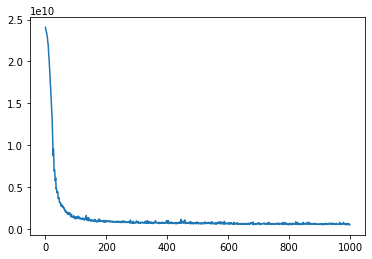

In [127]:
print(min(hist.history["loss"]), 511617024.0)
plt.plot(hist.history["loss"])

In [122]:
pred_df = pd.DataFrame(model.predict(tmp_train_x).squeeze(), index=tmp_train_md.index, columns=tmp_train_md.columns) \
.unstack().reset_index().drop(columns="level_0").rename(columns={0: "prediction"})

In [123]:
ori_df = pd.DataFrame(tmp_train_y.squeeze(),index=tmp_train_md.index, columns=tmp_train_md.columns)\
.unstack().reset_index().drop(columns="level_0").rename(columns={0: "quantity"})

F:\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


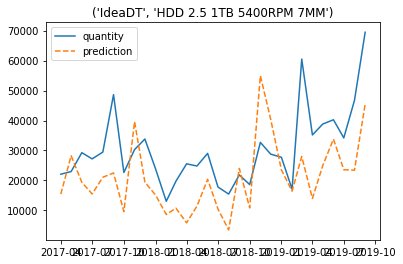

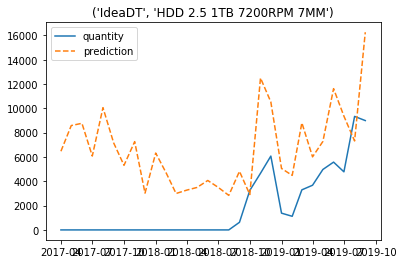

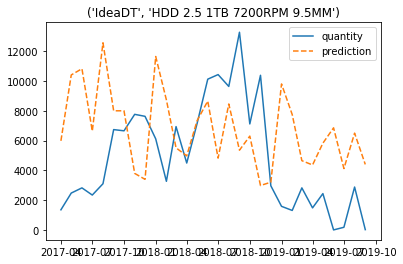

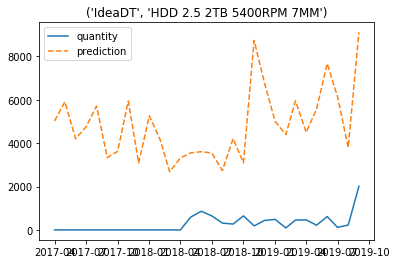

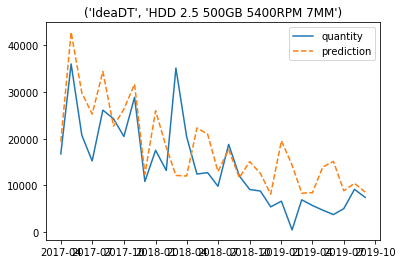

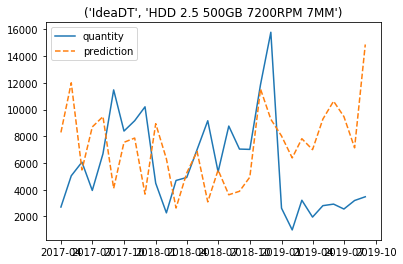

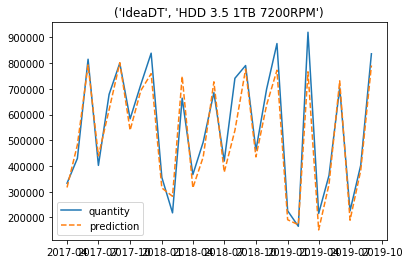

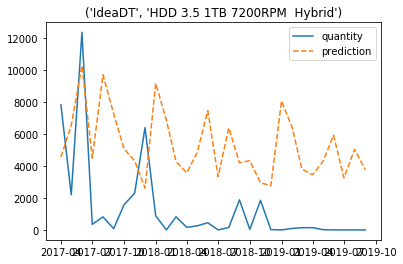

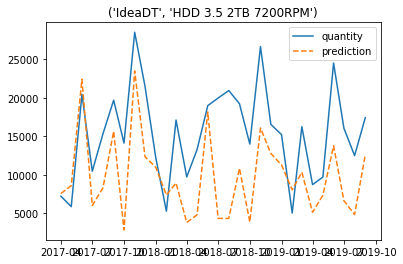

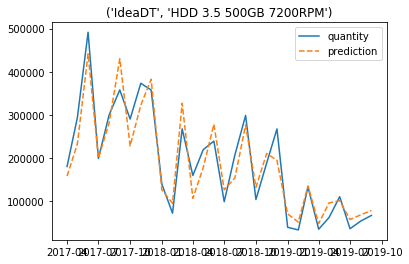

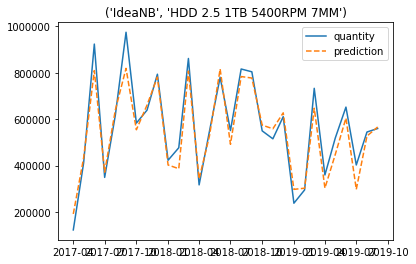

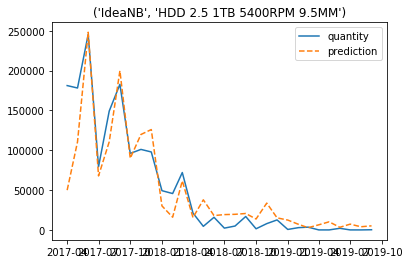

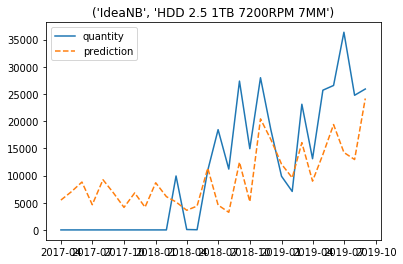

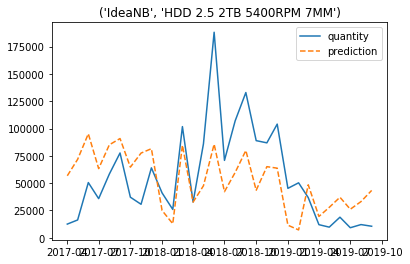

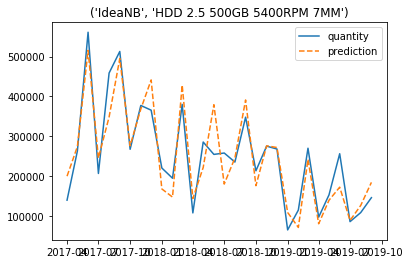

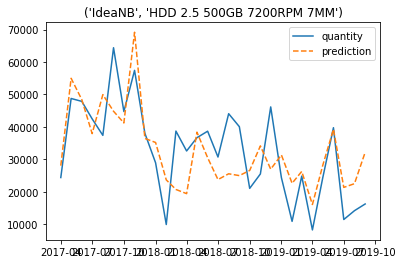

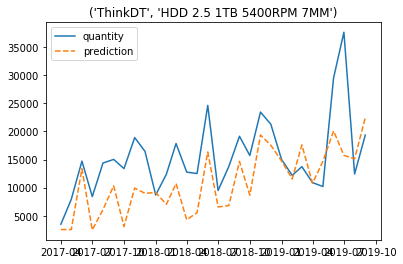

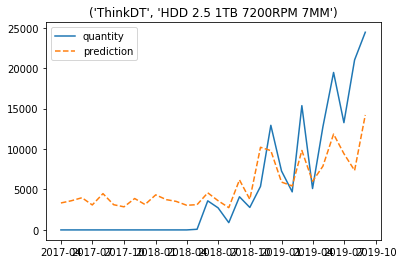

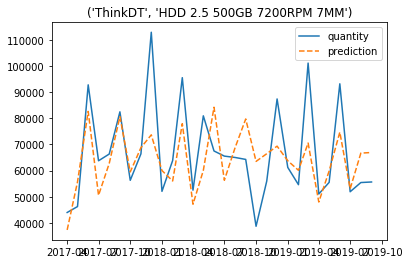

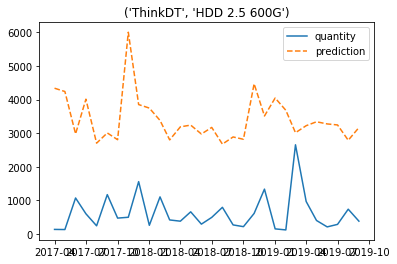

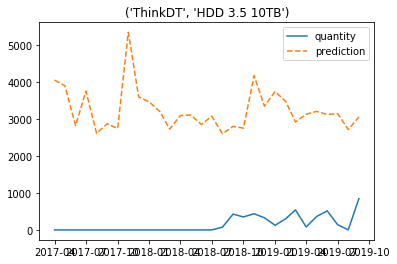

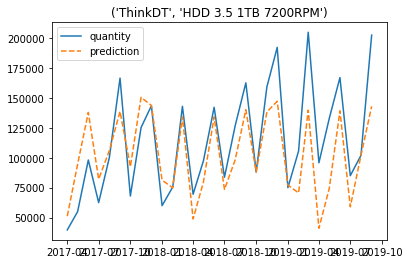

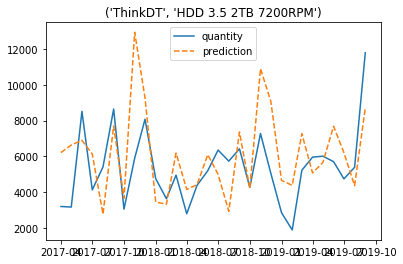

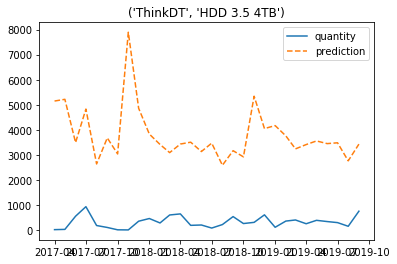

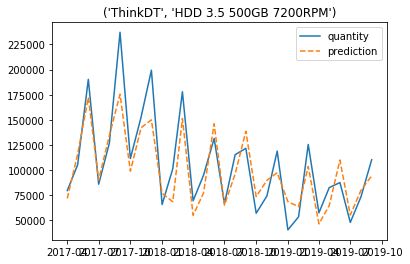

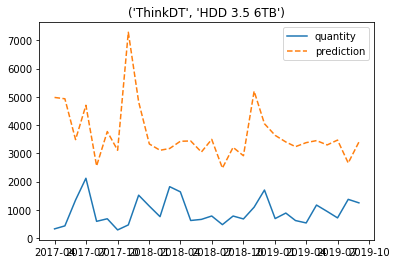

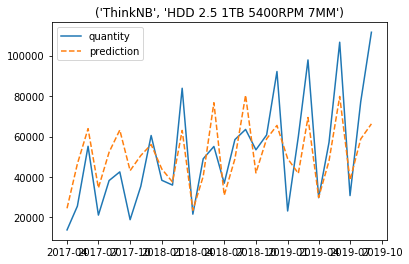

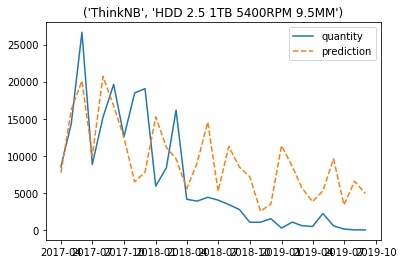

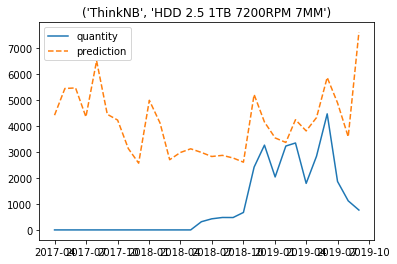

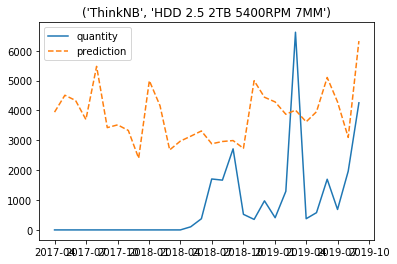

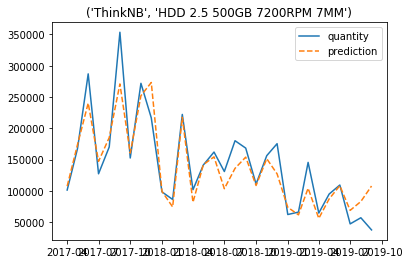

In [124]:
pred_df = pred_df.merge(ori_df, how="left", on=["bu", "item_group", "time_bucket"])
for _, grouped_df in pred_df.groupby(["bu", "item_group"]):
    plt.figure()
    plt.plot(pd.to_datetime(grouped_df["time_bucket"]), grouped_df["quantity"], label="quantity", linestyle="-")
    plt.plot(pd.to_datetime(grouped_df["time_bucket"]), grouped_df["prediction"], label="prediction", linestyle="--")
    plt.title(_)
    plt.legend()

In [125]:
pred_df = pd.DataFrame(model.predict(tmp_valid_x).squeeze(), index=tmp_valid_md.index, columns=tmp_valid_md.columns) \
.unstack().reset_index().drop(columns="level_0").rename(columns={0: "prediction"})
ori_df = pd.DataFrame(tmp_valid_y.squeeze(),index=tmp_valid_md.index, columns=tmp_valid_md.columns)\
.unstack().reset_index().drop(columns="level_0").rename(columns={0: "quantity"})
pred_df = pred_df.merge(ori_df, how="left", on=["bu", "item_group", "time_bucket"])

In [126]:
tmp_df = pred_df.loc[test_final_condition, :]
tmp_df.loc[:, "pred_hat"] = tmp_df.loc[test_final_condition, :] \
.apply(
    lambda x: pd.Series({
        "pred_hat": x["prediction"] if x["quantity"] > x["prediction"] else (2*x["quantity"] - x["prediction"])*(2*x["quantity"] > x["prediction"])}), axis=1)
tmp_df.groupby(["time_bucket"]).apply(lambda x: x["pred_hat"].sum()/x["quantity"].sum())

F:\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
F:\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


time_bucket
2019-10-01    0.739892
2019-11-01    0.726922
2019-12-01    0.685047
2020-01-01    0.610925
2020-02-01    0.402751
2020-03-01    0.540469
dtype: float64

In [57]:
time_bucket
2019-10-01    0.768525
2019-11-01    0.778085
2019-12-01    0.664700
2020-01-01    0.526698
2020-02-01    0.560577
2020-03-01    0.736408
dtype: float64

SyntaxError: invalid token (<ipython-input-57-ec16cc79049c>, line 2)